In [190]:
import torch
import torch.nn as nn
import torchvision
from livelossplot import PlotLosses

In [191]:
def cycle(iterable):
  while True:
    for x in iterable:
      yield x

In [192]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("The classes are:", *class_names, sep = ", ")

The classes are:, T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


In [193]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(28),
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=256, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(28),
        torchvision.transforms.ToTensor()
    ])),
batch_size=512, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'Size of training set: {len(train_loader.dataset)}')
print(f'Size of test set: {len(test_loader.dataset)}')

Size of training set: 60000
Size of test set: 10000


torch.Size([256, 1, 28, 28])


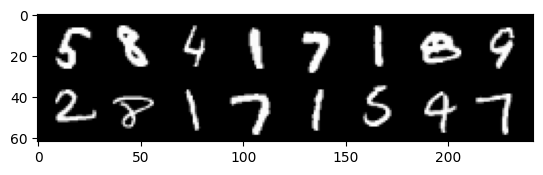

In [194]:
import matplotlib.pyplot as plt

x, y = next(train_iterator)

grid = torchvision.utils.make_grid(x[:16])
grid = (grid-grid.min())/(grid.max()-grid.min())

plt.imshow(grid.permute(1, 2, 0))

print(x.shape)

In [195]:
device = torch.device('cpu')
print(f'Device type is {device}.')

Device type is cpu.


In [196]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.l1 = nn.Linear(in_features=784, out_features=50)
        self.l2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.functional.relu(x)
        x = self.l2(x)
        return x

model = SimpleNetwork().to(device)
print(model)

SimpleNetwork(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)


In [197]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# initialising step variable
step = 0

# defining the loss function
# refer to https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()

# to plot losses
liveloss = PlotLosses()

# to keep the logs for loss plots
logs = {}

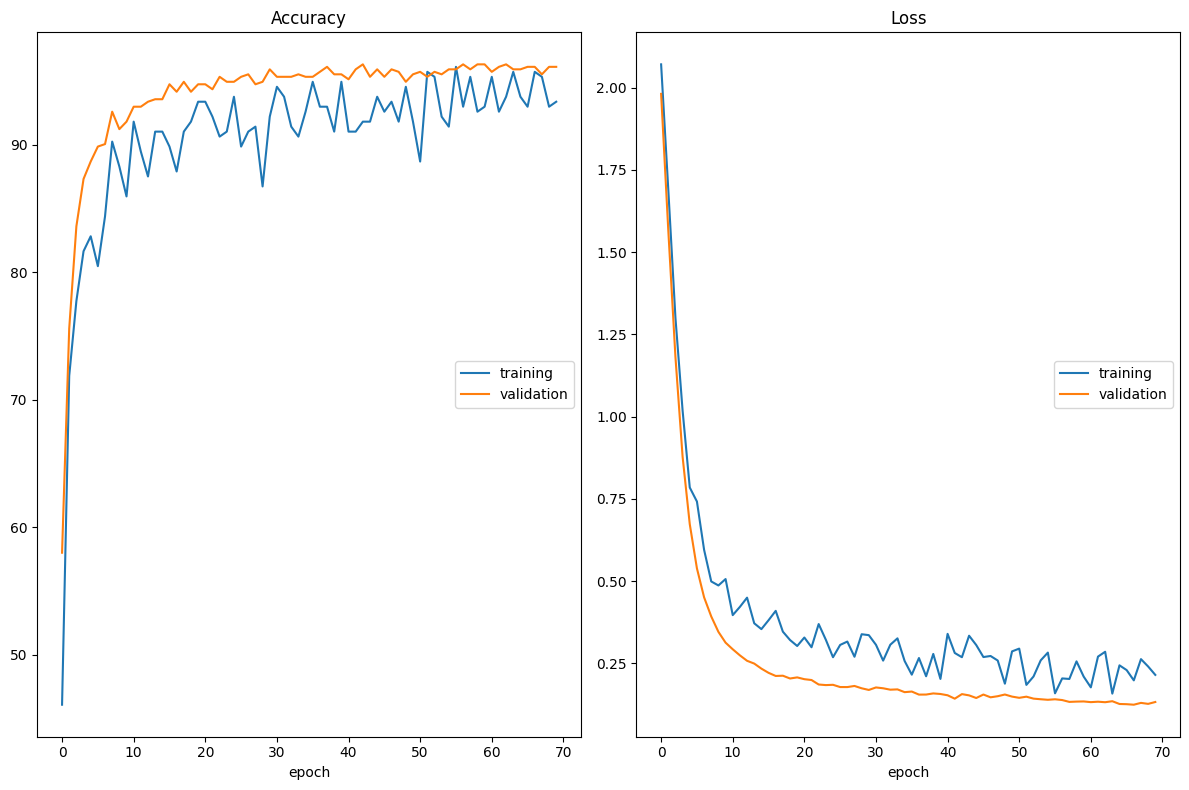

Accuracy
	training         	 (min:   46.094, max:   96.094, cur:   93.359)
	validation       	 (min:   58.008, max:   96.289, cur:   96.094)
Loss
	training         	 (min:    0.158, max:    2.071, cur:    0.215)
	validation       	 (min:    0.124, max:    1.981, cur:    0.132)


In [198]:
# outer loop - going over the steps we want to train for
while step < 500:
  # inner loop - iterating over the batches
  for i, batch in enumerate(train_loader):

    # getting the input and the ground truth labels from the training set
    x, gt = batch
    x, gt = x.to(device), gt.to(device)

    # forward pass
    x = x.view(x.size(0), -1)
    output = model(x)

    # loss
    loss = criterion(output, gt)

    # explicitly set the gradients to zero before backpropagation
    model.zero_grad()

    # backward pass
    loss.backward()
    optimiser.step()
    step += 1

    # calculating the accuracy
    _, argmax = torch.max(output, dim=1)
    accuracy = argmax.eq(gt).float().mean() * 100

    # every 50 steps we evaluate the model on the test set
    if step % 10 == 0:

      # when we test, we don't need gradients
      with torch.no_grad():

        # beginning the loop for evaluation:
        for j, test_batch in enumerate(test_loader):

          # getting the input and the ground truth labels from the training set
          x, gt = test_batch
          x, gt = x.to(device), gt.to(device)

          # forward pass
          x = x.view(x.size(0), -1)
          output = model(x)

          # test loss
          test_loss = criterion(output, gt)

          # calculating the test accuracy
          _, argmax = torch.max(output, dim=1)
          test_accuracy = argmax.eq(gt).float().mean() * 100

        # logging train and test losses and accuracies
        logs['Loss'] = loss.item()
        logs['val_Loss'] = test_loss.item()
        logs['Accuracy'] = accuracy.item()
        logs['val_Accuracy'] = test_accuracy.item()
        liveloss.update(logs)
        liveloss.send()

In [199]:
sum(p.numel() for p in model.parameters())

101766